# Data Sources

This dataset compiles data from the following Massachusetts Department of Education reports:

* Enrollment by Grade
* Enrollment by Selected Population
* Enrollment by Race/Gender
* Class Size by Gender and Selected Populations
* Teacher Salaries
* Per Pupil Expenditure
* Graduation Rates
* Graduates Attending Higher Ed
* Advanced Placement Participation
* Advanced Placement Performance
* SAT Performance
* MCAS Achievement Results
* Accountability Report
* In each case, the data is the latest available data as of August 2017.

### Data Dictionary

The data dictionary lists the report from which each field is sourced. It also includes the original field names - minor changes have been made to make the field names easier to understand. Data definitions can be found on the About the Data section of the MA DOE website.

### Questions

* What contributes to differences in students attending 4 years colleges?
* Are there meaningful regional differences within MA?
* Which schools do well despite limited resources?

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# might be needed depending on your version of Jupyter
%matplotlib inline

In [2]:
# Load in data
df = pd.read_csv('MA_Public_Schools_2017.csv')

#Check Number of Columns and Rows
print("Rows: " + str(df.shape[0]) + " Columns: " + str(df.shape[1]))

Rows: 1861 Columns: 302


In [4]:
# Trim down the unnecessary columns that only contain one unique entry
for col in df.columns:
    if len(df[col].unique())==1:
        df.drop(col,inplace=True,axis=1)


### Let's Focus on High Schools

In [5]:
# High Schools = schools with grade 12 enrollment
HS_df = df[df['12_Enrollment'] != 0].reset_index(drop=True)
HS_df.head()

,School Code,School Name,School Type,Contact Name,Address 1,Address 2,Town,Zip,Phone,Fax,...,MCAS_10thGrade_English_Incl. in SGP(#),Accountability and Assistance Level,Accountability and Assistance Description,School Accountability Percentile (1-99),Progress and Performance Index (PPI) - All Students,Progress and Performance Index (PPI) - High Needs Students,District_Accountability and Assistance Level,District_Accountability and Assistance Description,District_Progress and Performance Index (PPI) - All Students,District_Progress and Performance Index (PPI) - High Needs Students
0,10505,Abington High,Public School,Teresa Sullivan-Cruz,201 Gliniewicz Way,NaN,Abington,2351,781-982-2160,781-982-0061,...,111.0,Level 1,Meeting gap narrowing goals,42.0,76.0,75.0,Level 3,One or more schools in the district classified...,63.0,60.0
1,50505,Agawam High,Public School,Thomas Schnepp,760 Cooper Street,NaN,Agawam,1001,413-821-0521,413-821-0536,...,263.0,Level 2,Not meeting gap narrowing goals,41.0,65.0,61.0,Level 2,One or more schools in the district classified...,54.0,56.0
2,70505,Amesbury High,Public School,Elizabeth McAndrews,5 Highland Street,NaN,Amesbury,1913,978-388-4800,978-388-3393,...,133.0,Level 2,Not meeting gap narrowing goals,53.0,67.0,66.0,Level 2,One or more schools in the district classified...,50.0,46.0
3,70515,Amesbury Innovation High School,Public School,Eryn Maguire,71 Friend Street,NaN,Amesbury,1913,978-388-8037,978-388-8073,...,NaN,Insufficient data,NaN,NaN,NaN,NaN,Level 2,One or more schools in the district classified...,50.0,46.0
4,90505,Andover High,Public School,Philip Conrad,80 Shawsheen Road,NaN,Andover,1810,978-247-5500,978-247-5770,...,310.0,Level 2,Not meeting gap narrowing goals,81.0,85.0,64.0,Level 2,One or more schools in the district classified...,83.0,57.0


In [6]:
# Combine % 4 year public colleges and % 4 year private colleges into one stat
HS_df['% 4YR college'] = HS_df['% Private Four-Year'] + HS_df['% Public Four-Year']

# Get percentage of 4YR college from Graduation rate
HS_df['% 4YR college'] = HS_df['% 4YR college'] * (HS_df['% Graduated']/100)

#Remove unwanted information
HS_df = HS_df.drop(['% Private Four-Year',
              '% Public Four-Year',
              '% Graduated',
              '% Public Two-Year',
              '% MA Community College',
              '% Attending College'],axis=1)

# Accept high schools with at least 25 seniors
HS25 = HS_df.loc[HS_df['12_Enrollment'] >= 25].dropna(subset=['% 4YR college']).reset_index(drop=True)

<AxesSubplot:xlabel='% 4YR college', ylabel='Count'>

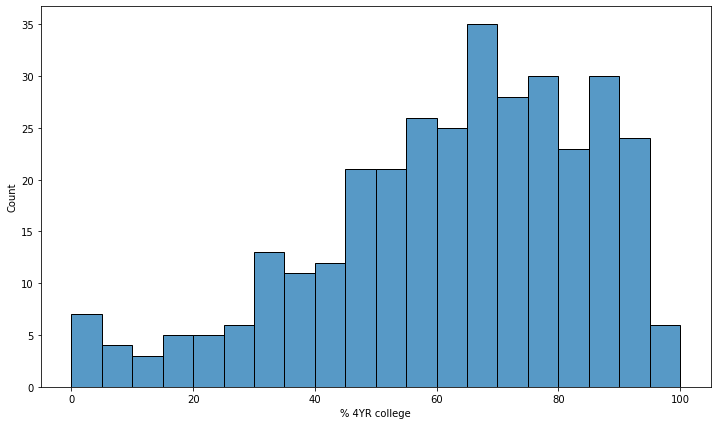

In [7]:
# View data to see which models will work
plt.figure(figsize=(12,7))
sns.histplot(data = HS25['% 4YR college'], bins=20)

In [8]:
# Identify null values in columns for elimination
HS25.isnull().sum()[HS25.isnull().sum()>100]

Address 2                                328
MCAS_3rdGrade_Math_P+A #                 334
% MCAS_3rdGrade_Math_P+A                 334
MCAS_3rdGrade_Math_A #                   334
% MCAS_3rdGrade_Math_A                   334
                                        ... 
% MCAS_8thGrade_English_W/F              316
MCAS_8thGrade_English_Stud. Incl. #      316
MCAS_8thGrade_English_CPI                316
MCAS_8thGrade_English_SGP                316
MCAS_8thGrade_English_Incl. in SGP(#)    316
Length: 165, dtype: int64

In [9]:
# exclude columns that have null in more than half of a category, most of them aren't relevant to High School
HS25 = HS25[HS25.columns[((pd.isnull(HS25).sum()) / (len(HS25)) < 0.5 ).values]]

In [10]:
# Work with numeric values only, but keep some like School Type for comparing later
SchoolType25 = HS25['School Type']

# Set the Index to the school name
HS25.set_index('School Name', inplace=True)

# Drop non-numeric variables
HS25 = HS25.select_dtypes(include=[np.number])

In [11]:
HS25.head()

,School Code,Zip,District Code,PK_Enrollment,K_Enrollment,1_Enrollment,2_Enrollment,3_Enrollment,4_Enrollment,5_Enrollment,...,MCAS_10thGrade_English_Stud. Incl. #,MCAS_10thGrade_English_CPI,MCAS_10thGrade_English_SGP,MCAS_10thGrade_English_Incl. in SGP(#),School Accountability Percentile (1-99),Progress and Performance Index (PPI) - All Students,Progress and Performance Index (PPI) - High Needs Students,District_Progress and Performance Index (PPI) - All Students,District_Progress and Performance Index (PPI) - High Needs Students,% 4YR college
School Name,,,,,,,,,,,,,,,,,,,,,
Abington High,10505,2351,10000,0,0,0,0,0,0,0,...,124.0,98.8,56.0,111.0,42.0,76.0,75.0,63.0,60.0,64.3960
Agawam High,50505,1001,50000,0,0,0,0,0,0,0,...,287.0,98.3,51.0,263.0,41.0,65.0,61.0,54.0,56.0,62.1720
Amesbury High,70505,1913,70000,0,0,0,0,0,0,0,...,149.0,95.6,41.0,133.0,53.0,67.0,66.0,50.0,46.0,60.4716
Andover High,90505,1810,90000,0,0,0,0,0,0,0,...,408.0,99.5,42.0,310.0,81.0,85.0,64.0,83.0,57.0,88.4268
Arlington High,100505,2476,100000,0,0,0,0,0,0,0,...,294.0,99.1,43.5,264.0,73.0,79.0,86.0,76.0,56.0,88.6824


In [12]:
#Drop more unnecessary columns
HS25.drop(['School Code',
           'Zip',
           'District Code',
           'PK_Enrollment',
           'K_Enrollment',
           '1_Enrollment',
           '2_Enrollment',
          '3_Enrollment',
          '4_Enrollment',
          '5_Enrollment',
          '6_Enrollment',
          '7_Enrollment',
          '8_Enrollment'],inplace = True,axis=1)

In [13]:
# Fill in missing values with median
HS25 = HS25.fillna(HS25.median())

In [14]:
# Check if there are any null values left
HS25.isnull().sum()

9_Enrollment                                                           0
10_Enrollment                                                          0
11_Enrollment                                                          0
12_Enrollment                                                          0
SP_Enrollment                                                          0
                                                                      ..
Progress and Performance Index (PPI) - All Students                    0
Progress and Performance Index (PPI) - High Needs Students             0
District_Progress and Performance Index (PPI) - All Students           0
District_Progress and Performance Index (PPI) - High Needs Students    0
% 4YR college                                                          0
Length: 98, dtype: int64

In [15]:
#Check for largest POSITIVE correlations with % 4YR college
HS25.corr()['% 4YR college'].sort_values().head(10)

% Economically Disadvantaged   -0.802646
% High Needs                   -0.790570
% MCAS_10thGrade_Math_NI       -0.728705
% Dropped Out                  -0.713873
% MCAS_10thGrade_English_NI    -0.694087
% MCAS_10thGrade_Math_W/F      -0.663215
% MCAS_10thGrade_English_P     -0.649399
% Hispanic                     -0.594107
% Still in School              -0.571137
% AP_Score 1-2                 -0.544334
Name: % 4YR college, dtype: float64

In [16]:
#Check for largest POSITIVE correlations with % 4YR college
HS25.corr()['% 4YR college'].sort_values(ascending=False).head(10)

% 4YR college                              1.000000
% MCAS_10thGrade_Math_A                    0.778880
% MCAS_10thGrade_English_A                 0.768194
% MCAS_10thGrade_Math_P+A                  0.761522
MCAS_10thGrade_Math_CPI                    0.727560
School Accountability Percentile (1-99)    0.710407
Average SAT_Writing                        0.699393
Average SAT_Math                           0.693240
% MCAS_10thGrade_English_P+A               0.681620
Average SAT_Reading                        0.660601
Name: % 4YR college, dtype: float64

## Linear Regression Training and Testing

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# Split the data into training and testing sets with some of the highest correlations
y = HS25['% 4YR college']
X = HS25[['% Economically Disadvantaged']]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Train The Model

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
# Create the model and train/fit
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [57]:
#Check R-squared score, the closer to 1 the better.
lm.fit(X_train,y_train).score(X_train,y_train)

0.6466474810338791

In [22]:
# print out the coefficients of the model
print('Coefficients: ', lm.coef_)

Coefficients:  [-0.99276197]


## Predicting Test Data

In [23]:
predictions = lm.predict(X_test)

Text(0, 0.5, 'Predicted Y')

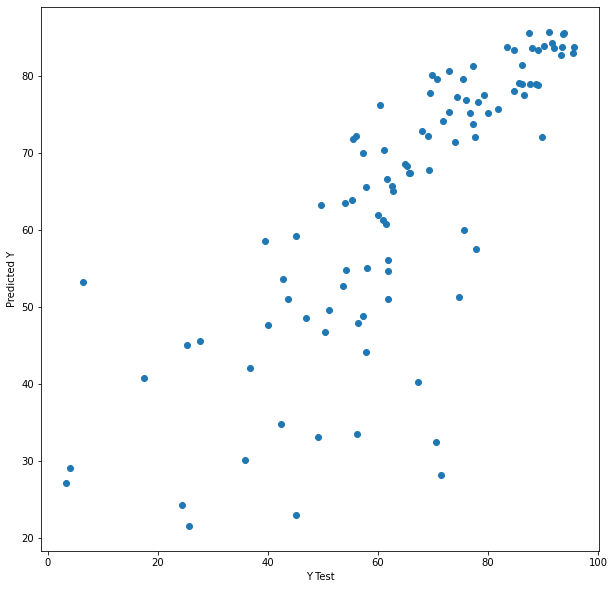

In [26]:
plt.figure(figsize=(10,10))
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

<AxesSubplot:xlabel='% 4YR college', ylabel='Count'>

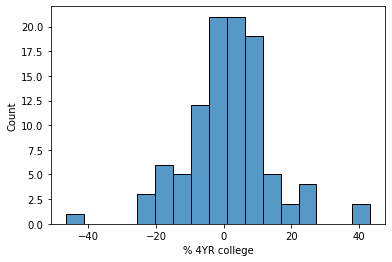

In [37]:
sns.histplot((y_test-predictions))

## Evaluate the Model

School Name
Abington High                  64.3960
Agawam High                    62.1720
Amesbury High                  60.4716
Andover High                   88.4268
Arlington High                 88.6824
                                ...   
Doherty Memorial High          57.0544
North High                     28.0722
South High Community           38.6584
University Pk Campus School    70.6374
Worcester Technical High       46.1279
Name: % 4YR college, Length: 335, dtype: float64

In [38]:
# calculate these metrics
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 9.27065605581817
MSE: 162.24506729533525
RMSE: 12.737545575790309


## Clean Up Data 
#### Check for Residuals and Exclude them

Text(0.5, 6.800000000000029, 'Percent of Economically Disadvantage Students')

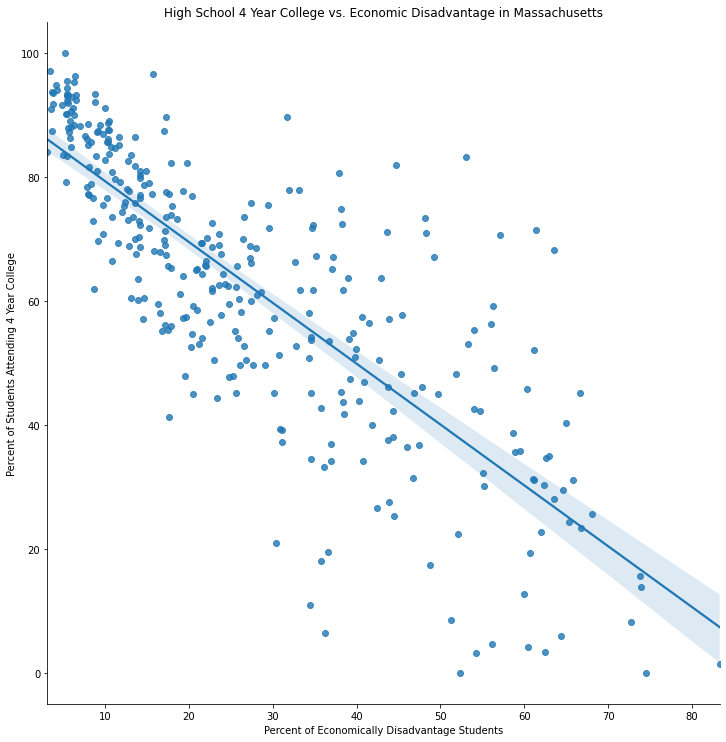

In [28]:
# Look at Linear Model plot of the data
sns.lmplot(data = HS25, 
           x= '% Economically Disadvantaged', 
           y = '% 4YR college', 
           height=10)

plt.title("High School 4 Year College vs. Economic Disadvantage in Massachusetts")
plt.ylabel("Percent of Students Attending 4 Year College")
plt.xlabel("Percent of Economically Disadvantage Students")

Text(0.5, 0, 'Percent of Economically Disadvantage Students')

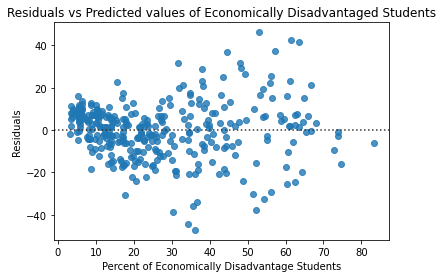

In [50]:
# Look at Linear Model plot of the data
sns.residplot(data = HS25, 
           x = '% Economically Disadvantaged', 
           y = '% 4YR college')

plt.title("Residuals vs Predicted values of Economically Disadvantaged ")
plt.ylabel("Residuals")
plt.xlabel("Percent of Economically Disadvantage Students")

#### Clearly, the more disadvantaged the school, the results are more wildly spread. Lets see what type of schools these are.

In [69]:
HS25['School Type'] = SchoolType25.values
HS25 = HS25[['School Type','% Economically Disadvantaged','% 4YR college']]

In [70]:
HS25 = pd.concat([HS25, pd.Series(y-lm.predict(X), name = 'residual')], axis = 1)

In [71]:
# Lets look at the schools with Positive Residuals
HS25 = HS25.sort_values(ascending=False,by=['residual'])
HS25.loc[HS25['residual'] > 20]

,School Type,% Economically Disadvantaged,% 4YR college,residual
School Name,,,,
New Mission High School,Public School,53.1,83.2041,46.773626
Another Course To College,Public School,61.4,71.4766,43.286050
Quincy Upper School,Public School,63.6,68.2248,42.218327
University Pk Campus School,Public School,57.1,70.6374,38.177974
O'Bryant School Math/Science,Public School,44.7,81.9292,37.159525
Boston Latin Academy,Public School,31.7,89.7294,32.053820
KIPP Academy Lynn Charter School,Charter School,48.1,73.3773,31.983016
Fenway High School,Public School,48.3,71.0370,29.841269
Prospect Hill Academy Charter School,Charter School,37.9,80.7625,29.242044


In [72]:
# These schools are Exam Schools in Boston lets change the type as of 2017
HS25.loc[(HS25.index == "Boston Latin Academy") | 
            (HS25.index == "O'Bryant School Math/Science") |
            (HS25.index == "Boston Latin"), 'School Type'] = 'Exam School'

In [73]:
# These schools are Pilot Schools in Boston lets change the type as of 2017
HS25.loc[(HS25.index == "Another Course To College") | 
            (HS25.index == "Boston Arts Academy") | 
            (HS25.index == "Boston Community Leadership Academy") |
            (HS25.index == "Fenway High School") |
            (HS25.index == "Greater Egleston Community High School") |
            (HS25.index == "Lyon Upper 9-12") |
            (HS25.index == "New Mission High School") |
            (HS25.index == "Quincy Upper School") |
            (HS25.index == "TechBoston Academy"), 'School Type'] = 'Pilot School'

In [74]:
HS25.loc[HS25['residual'] > 20].sort_values(ascending=True,by=['School Type'])

,School Type,% Economically Disadvantaged,% 4YR college,residual
School Name,,,,
Salem Academy Charter School,Charter School,31.9,77.8696,20.392572
KIPP Academy Lynn Charter School,Charter School,48.1,73.3773,31.983016
Pioneer Charter School of Science,Charter School,38.1,74.8064,23.484496
Prospect Hill Academy Charter School,Charter School,37.9,80.7625,29.242044
Academy Of the Pacific Rim Charter Public School,Charter School,38.3,72.4245,21.301149
City on a Hill Charter Public School Circuit Street,Charter School,56.3,59.2835,26.029864
Boston Green Academy Horace Mann Charter School,Charter School,61.1,52.1646,23.676222
Boston Latin,Exam School,15.7,96.6285,23.068728
O'Bryant School Math/Science,Exam School,44.7,81.9292,37.159525


In [75]:
# Now lets look at schools with Negative residuals
HS25.loc[HS25['residual'] < -20].sort_values(ascending=True,by=['residual'])

,School Type,% Economically Disadvantaged,% 4YR college,residual
School Name,,,,
Medford Vocational Technical High,Public School,36.2,6.5065,-46.701651
Westfield Technical Academy,Public School,34.4,10.8960,-44.099123
The Gateway to College,Public School,30.4,20.8854,-38.080771
Fecteau-Leary Junior/Senior High School,Public School,52.3,0.0000,-37.224684
Franklin County Technical,Public School,35.7,18.1200,-35.584532
Pathfinder Vocational Technical,Public School,36.6,19.4575,-33.353546
Edison Academy,Public School,54.2,3.2558,-32.082636
Old Colony Regional Vocational Technical,Public School,17.6,41.3100,-30.363524
Boston Adult Academy,Public School,51.3,8.5560,-29.661446


In [76]:
# These schools are listed as for adults or special needs so we'll call them Specialist School as of 2017
HS25.loc[(HS25.index == "Boston Adult Academy") | 
          (HS25.index == "Edison Academy") |
          (HS25.index == "The Gateway to College") |
          (HS25.index == "Greater Egleston Community High School") |
          (HS25.index == "Boston Day and Evening Academy Charter School"), 
          'School Type'] = 'Specialist School'

In [77]:
# Lets now take a look at Public schools only
HS25_Public =  HS25.loc[(HS25['School Type'] == 'Public School')]
HS25_Public

,School Type,% Economically Disadvantaged,% 4YR college,residual
School Name,,,,
University Pk Campus School,Public School,57.1,70.6374,38.177974
North Quincy High,Public School,33.1,77.9790,21.693287
Wareham Senior High,Public School,42.9,63.6870,17.130354
Quincy High,Public School,34.7,71.7600,17.062706
Drury High,Public School,53.3,53.1542,16.922278
...,...,...,...,...
Pathfinder Vocational Technical,Public School,36.6,19.4575,-33.353546
Franklin County Technical,Public School,35.7,18.1200,-35.584532
Fecteau-Leary Junior/Senior High School,Public School,52.3,0.0000,-37.224684


### Rerun the model

Text(0.5, 6.800000000000029, 'Percent of Economically Disadvantage Students')

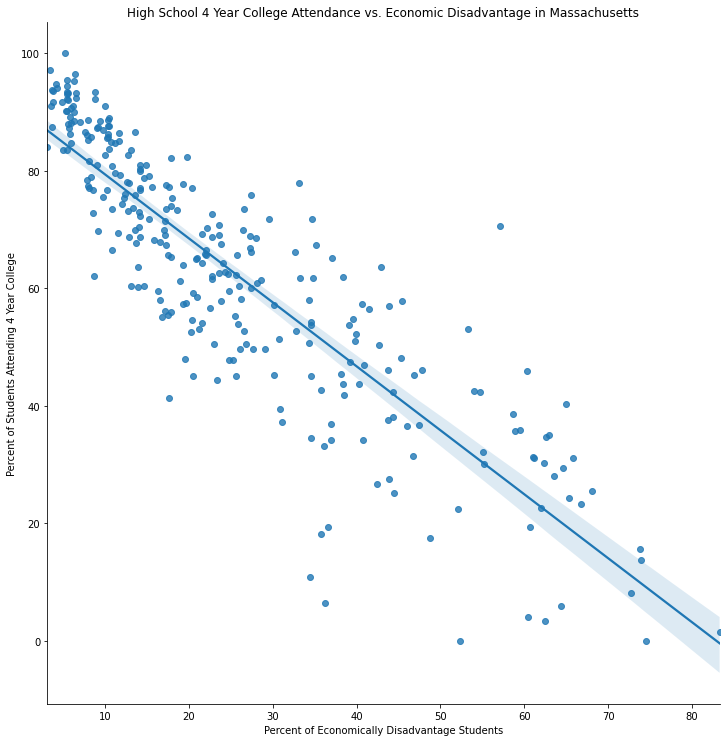

In [78]:
sns.lmplot(data = HS25_Public, x= '% Economically Disadvantaged', y = '% 4YR college', height=10)

plt.title("High School 4 Year College Attendance vs. Economic Disadvantage in Massachusetts")
plt.ylabel("Percent of Students Attending 4 Year College")
plt.xlabel("Percent of Economically Disadvantage Students")

In [80]:
# New Response Variable
y = HS25_Public['% 4YR college']
# New Explanatory Variable
X = HS25_Public[['% Economically Disadvantaged']]
# Set up training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
#fit linear regression model
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [83]:
print('Coefficients: ', lm.coef_)

Coefficients:  [-1.07595366]


In [88]:
#Check R-squared score, the closer to 1 the better.
lm.fit(X_train,y_train).score(X_train,y_train)

0.7469371405745211

### Linear Regression again

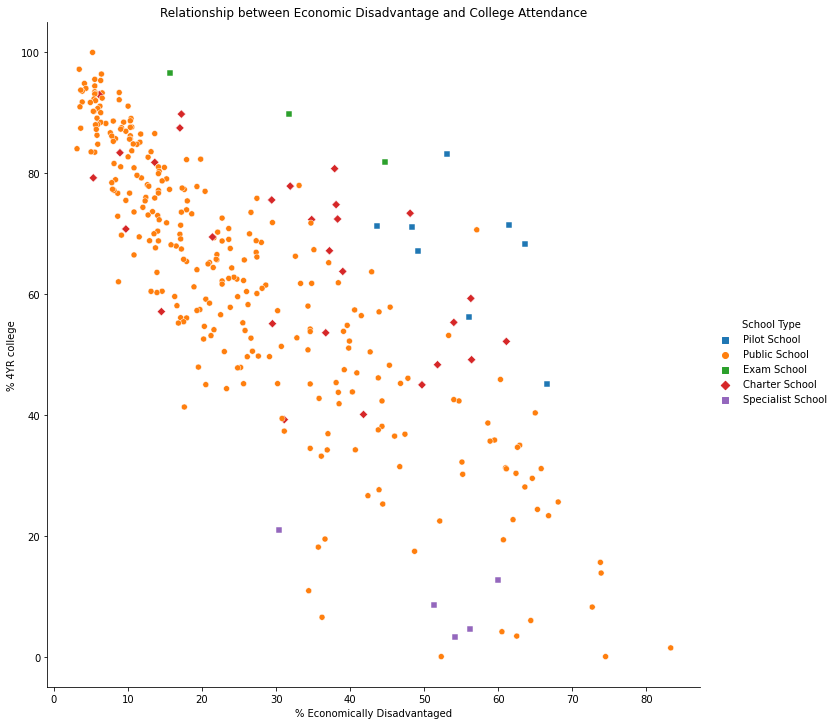

In [108]:
sns.pairplot(HS25,
                 x_vars=['% Economically Disadvantaged'],
                 y_vars=['% 4YR college'],
                 hue='School Type',
                 markers=['s','o','s','D','s'],
                 height = 10,
                 diag_kind=None)
plt.title('Relationship between Economic Disadvantage and College Attendance');

## Lets take a look at the over and under performing schools
We can see from the pairplot that many of the positive outliers are Pilot, Exam and Charter schools

In [116]:
HS25.loc[HS25['residual']>25]

,School Type,% Economically Disadvantaged,% 4YR college,residual
School Name,,,,
New Mission High School,Pilot School,53.1,83.2041,46.773626
Another Course To College,Pilot School,61.4,71.4766,43.286050
Quincy Upper School,Pilot School,63.6,68.2248,42.218327
University Pk Campus School,Public School,57.1,70.6374,38.177974
O'Bryant School Math/Science,Exam School,44.7,81.9292,37.159525
Boston Latin Academy,Exam School,31.7,89.7294,32.053820
KIPP Academy Lynn Charter School,Charter School,48.1,73.3773,31.983016
Fenway High School,Pilot School,48.3,71.0370,29.841269
Prospect Hill Academy Charter School,Charter School,37.9,80.7625,29.242044


### Note the lone public school in the list: 
University Pk Campus School

In [117]:
HS25.loc[HS25['residual']<-25]

,School Type,% Economically Disadvantaged,% 4YR college,residual
School Name,,,,
Boston Day and Evening Academy Charter School,Specialist School,56.2,4.5962,-28.756712
Boston Adult Academy,Specialist School,51.3,8.5560,-29.661446
Old Colony Regional Vocational Technical,Public School,17.6,41.3100,-30.363524
Edison Academy,Specialist School,54.2,3.2558,-32.082636
Pathfinder Vocational Technical,Public School,36.6,19.4575,-33.353546
Franklin County Technical,Public School,35.7,18.1200,-35.584532
Fecteau-Leary Junior/Senior High School,Public School,52.3,0.0000,-37.224684
The Gateway to College,Specialist School,30.4,20.8854,-38.080771
Westfield Technical Academy,Public School,34.4,10.8960,-44.099123


We also could see that the specialist schools for adults and kids who need special attention